In [1]:
#Importing Keras packages
from __future__ import print_function
import os
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras import optimizers
from tensorflow.keras.preprocessing import image
from keras.layers.advanced_activations import ELU, LeakyReLU, PReLU, Softmax, ReLU
from keras.regularizers import l2
from tensorflow.keras import initializers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

Using TensorFlow backend.


In [2]:
#Ensuring the model is built on the existing GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1
physical_devices------------- 1


In [3]:
#Data Importing, Pre-processing and Inspection
my_data_dir = 'C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\Malaria\\cell_images'

In [4]:
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [5]:
os.listdir(my_data_dir)
os.listdir(test_path)
os.listdir(train_path)
os.listdir(train_path+'\\infected')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

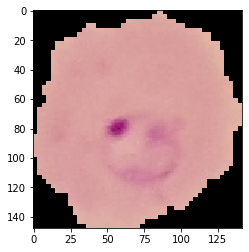

In [6]:
para_cell = train_path+'\\infected'+'\\C100P61ThinF_IMG_20150918_144104_cell_162.png'
para_img= imread(para_cell)
plt.imshow(para_img)

In [7]:
para_img.shape

(148, 142, 3)

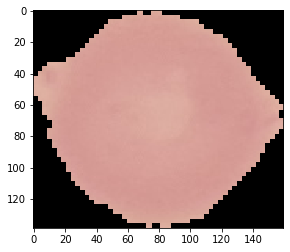

In [8]:
unifected_cell_path = train_path+'\\uninfected\\'+os.listdir(train_path+'\\uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

In [9]:
len(os.listdir(train_path+'\\infected'))

12480

In [10]:
len(os.listdir(train_path+'\\uninfected'))

12480

In [11]:
unifected_cell.shape

(139, 160, 3)

In [12]:
para_img.shape

(148, 142, 3)

In [13]:
image_shape = (128,128,3)
input_shape = image_shape

In [14]:
#Data Augmentation setup
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rotation_range = 15, # rotate the image 20 degrees
                               width_shift_range = 0.20, # Shift the pic width by a max of 5%
                               height_shift_range = 0.20, # Shift the pic height by a max of 5%
                               rescale = 1/255, # Rescale the image by normalzing it.
                               shear_range = 0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range = 0.2, # Zoom in by 10% max
                               horizontal_flip = True, # Allo horizontal flipping
                               )
image_gen.flow_from_directory(train_path)
image_gen.flow_from_directory(test_path)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [15]:
#Initiating LiteNet for training
model = Sequential()

#1st Layer
model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = input_shape, activation = 'relu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())

#2nd Layer
model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = input_shape, activation = 'relu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())

#Pooling with Dropout
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.10))

#3rd Layer
model.add(Conv2D(128, (3, 3), padding = 'same', input_shape = input_shape, activation = 'relu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())

#4th Layer
model.add(Conv2D(128, (3, 3), padding = 'same', input_shape = input_shape, activation = 'relu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())

#Pooling with Dropout
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.10))

#5th Layer
model.add(Conv2D(256, (3, 3), padding = 'same', input_shape = input_shape, activation = 'relu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())

#6th Layer
model.add(Conv2D(256, (3, 3), padding = 'same', input_shape = input_shape, activation = 'relu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())

#Pooling with Dropout
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.10))

#7th Layer
model.add(Conv2D(512, (3, 3), padding = 'same', input_shape = input_shape, activation = 'relu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())

#8th Layer
model.add(Conv2D(512, (3, 3), padding = 'same', input_shape = input_shape, activation = 'relu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())

#Pooling with Dropout
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.15))

#9th Layer = 1st Fully Connected or Dense Layer
model.add(Flatten())
model.add(Dense(512, activation = 'relu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())
model.add(Dropout(0.15))

#10th Layer = 2nd Fully Connected or Dense Layer
model.add(Dense(512, activation = 'relu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())
model.add(Dropout(0.15))

#11th Layer = Final Layer
model.add(Dense(1, kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(Activation('sigmoid'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)      

In [16]:
#Setting up training
model.compile(loss = 'binary_crossentropy',
              optimizer = keras.optimizers.Adam(lr = 0.001),
              metrics = ['accuracy'])

batch_size = 32

train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size = image_shape[:2],
                                               color_mode = 'rgb',
                                               batch_size = batch_size,
                                               class_mode = 'binary')

test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size = image_shape[:2],
                                               color_mode = 'rgb',
                                               batch_size = batch_size,
                                               class_mode = 'binary',shuffle=False)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [17]:
#Model testing
results = model.fit_generator(train_image_gen, epochs = 10, validation_data = test_image_gen)  

#Saving model weights
from tensorflow.keras.models import load_model
model.save('C:\\Users\\Admin\\Desktop\\Research\\Results\\LiteNet Results\\Weights\\Malaria_LiteNet_RELU_Adam.h5')

Epoch 1/10
780/780 [==============================] - 138s 177ms/step - loss: 2.3875 - accuracy: 0.8566 - val_loss: 1.1027 - val_accuracy: 0.8965
Epoch 2/10
780/780 [==============================] - 131s 168ms/step - loss: 0.7765 - accuracy: 0.9225 - val_loss: 0.3529 - val_accuracy: 0.9100
Epoch 3/10
780/780 [==============================] - 131s 168ms/step - loss: 0.4987 - accuracy: 0.9212 - val_loss: 0.2998 - val_accuracy: 0.9035
Epoch 4/10
780/780 [==============================] - 131s 168ms/step - loss: 0.4155 - accuracy: 0.9210 - val_loss: 0.2892 - val_accuracy: 0.8865
Epoch 5/10
780/780 [==============================] - 131s 168ms/step - loss: 0.4245 - accuracy: 0.9192 - val_loss: 0.3204 - val_accuracy: 0.8465
Epoch 6/10
780/780 [==============================] - 131s 167ms/step - loss: 0.4325 - accuracy: 0.9181 - val_loss: 0.2582 - val_accuracy: 0.9015
Epoch 7/10
780/780 [==============================] - 130s 167ms/step - loss: 0.4445 - accuracy: 0.9211 - val_loss: 0.3401 -

In [18]:
#Model evaluation
model.evaluate_generator(test_image_gen)

[0.5323981642723083, 0.8938461542129517]

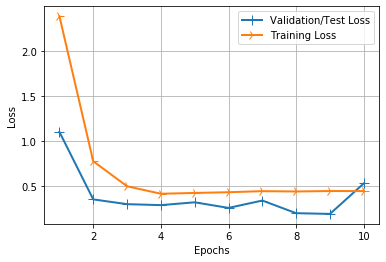

In [19]:
history_dict = results.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')
plt.setp(line1, linewidth = 2.0, marker = '+', markersize = 10.0)
plt.setp(line2, linewidth = 2.0, marker = '4', markersize = 10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [20]:
#Classification report
from sklearn.metrics import classification_report,confusion_matrix
pred_probabilities = model.predict_generator(test_image_gen)
predictions = pred_probabilities > 0.5
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      1300
           1       0.85      0.98      0.91      1300

    accuracy                           0.90      2600
   macro avg       0.91      0.90      0.90      2600
weighted avg       0.91      0.90      0.90      2600



In [21]:
#Model prediction
para_cell
my_image = image.load_img(para_cell, target_size = image_shape)
my_image
my_image = image.img_to_array(my_image)
my_image.shape

(128, 128, 3)

In [22]:
my_image = np.expand_dims(my_image, axis = 0)
my_image.shape

(1, 128, 128, 3)

In [23]:
train_image_gen.class_indices

{'infected': 0, 'uninfected': 1}

In [24]:
model.predict(my_image)

array([[1.3348072e-32]], dtype=float32)